<a href="https://colab.research.google.com/github/CharlesAttend/M1-S2-DAC/blob/main/RITAL/TAL/TME/TME4/4a_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [1]:
!wget https://thome.isir.upmc.fr/classes/RITAL/input.txt

--2023-02-17 16:01:28--  https://thome.isir.upmc.fr/classes/RITAL/input.txt
Resolving thome.isir.upmc.fr (thome.isir.upmc.fr)... 134.157.18.247
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  1.55MB/s    in 0.7s    

2023-02-17 16:01:30 (1.55 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
! pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 5.8 MB/s eta 0:00:00


In [3]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('./input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)


file_len = 1115394


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk` 
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [4]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)
    
    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters. 

(tensor([[12, 30, 27, 29, 28, 34, 96, 32, 18, 29],
        [21, 18, 15, 14, 94, 13, 18, 13, 94, 21],
        [94, 17, 24, 21, 34, 94, 43, 10, 27, 27],
        [14, 94, 24, 15, 94, 38, 21, 10, 27, 14]]), tensor([[30, 27, 29, 28, 34, 96, 32, 18, 29, 17],
        [18, 15, 14, 94, 13, 18, 13, 94, 21, 24],
        [17, 24, 21, 34, 94, 43, 10, 27, 27, 34],
        [94, 24, 15, 94, 38, 21, 10, 27, 14, 23]]))


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [5]:
import torch.nn.functional as f

class RNN(nn.Module):
    
    def __init__(self, n_char, hidden_size, output_size, n_layers=1, rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()
        
        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)  
        self.embed = nn.Embedding(n_char, hidden_size)
        
        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)  
        self.rnn = rnn_cell(hidden_size, hidden_size, num_layers=n_layers)
        
        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)  
        self.predict = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output
    
    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden


## Text generation function

Sample text from the model

In [6]:
def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)
            
    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted



## Training loop for net

In [7]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 5
lr = 0.005
batch_size = 16
chunk_len = 80

####

model = RNN(n_characters, hidden_size, n_characters, n_layers) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad() 
    
    # predict output
    output = model(inp)
    
    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1)) 

    #compute gradients and backpropagate
    loss.backward() 
    model_optimizer.step() 

    return loss.data.item() 



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk 
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')
       


    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 11s (100 0%) 3.1890]
Whonte nfosest m s
hapIe npd , t  f t mys rat ce ig t mo, o dle le t trot toloduweAbe,
 ce t  s  husof 

 23s (200 1%) 2.8727]
Whe  mhe an comorerenn srra t.DHulminsthyhotr  kome th d ce ulre
Y oanethon.T thhowocehe ut t t ess am 

 27s (300 1%) 2.6631]
Whe bigo yo s t iy

NO
Mvone as bafundo w peatI ly batr fe?


wad.
Acemes meare t t ivis laicus t that 

 33s (400 2%) 2.7143]
Wherep s hanoutheethas thilan sinthtous beenlor t me, s nkeps timethenne;Aqe thas l for ss?
Hand at PL 

 38s (500 2%) 2.5318]
Whe nd aioul;
Bothewe.
ingin ate nd wea, crapnte fre wofanlere her s belord atinl f ad n s,
T mle pond 

 44s (600 3%) 2.5967]
Whin fo me fn, ls bl ashour wthile conghestthas wee, by fongsd tt, woml ontar mitere ar? men s, for th 

 49s (700 3%) 2.5524]
Whe. omatheilllll, IO he pouimal me tomesthin, t, s hig taboue t manayOUS:

'k my GAB:
he t h ss s.


 

 54s (800 4%) 2.6368]
Whin re si iransins:
Tyoreanst my pe bly,
ENTine, tins nd barst, s ouss band somext,
Whof

## Visualize loss 

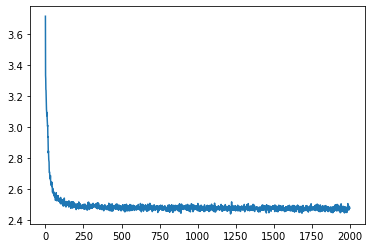

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [9]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")

print(generate(model,'Th', 200, temperature=0.5))
print("----")

print(generate(model,'Th', 200, temperature=0.3))
print("----")

print(generate(model,'Th', 200, temperature=0.1))

Thalle hetig alathat woe ncecls akee doranongice thaglt, p whinsoant in l d andot t nd til hittheger
Tyondoure CO:
CS:
S:
IO:
Seat I'd 'nd.
Ousthad:
Se t fan. ire ss cit wnd d
MELUCot ne te w, ot ha th
----
Th adrareathoulle min, ato awan, ay; cit th,
Y:
Whthe br t bustheathe ure thit sw, coul me, t Watoit t Ge hee s acerif de thirineetha ar vere the:

LAnd is leg ICI tagseal mourirdon t hir'e ERDI t he ST
----
Than hape pr the th.
TIO:

Th the I ine mend the us the t t my, ir st t and ce hanthe this sthareathe the, d this I heard mind banghe the are thithe or the thithe h we heathe le t in ce wingis win I t w
----
The the I thanghino the the the t the it thathe the t the thange thend the the the athe the s the t s the the ther thind t be the theathe the thind ther t s and thathe thind thind wis the thathe thithe 
----
The the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

### Improving this code:

(a) Tinker with parameters:

- Is it really necessary to have 100 dims character embeddings
- Chunk length can be gradually increased
- Try changing RNN cell type (GRUs - LSTMs)

(b) Add GPU support to go faster
